# Experiment 10-1

A rerun of the experiments in `experiment-10.ipynb` with more a more concise plan.

In [1]:
## Imports

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scikit_posthocs as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx

import logging

from src.simulation import Simulation
from src.network import Network
from src.render import Render

logging.disable(logging.CRITICAL)

In [2]:
network_file_1 = "networks/Environment1.inp"
network_file_2 = "networks/Environment2.inp"
network_file_3 = "networks/Environment3.inp"

env1 = Network(network_file_1)
env2 = Network(network_file_2)
env3 = Network(network_file_3)

g_env1 = env1.water_network_model.to_graph().to_undirected()
g_env2 = env2.water_network_model.to_graph().to_undirected()
g_env3 = env3.water_network_model.to_graph().to_undirected()

d_env1 = g_env1.degree
d_env2 = g_env2.degree
d_env3 = g_env3.degree

env1_start_pool = [node for node, degree in d_env1 if degree == 1]
env2_start_pool = [node for node, degree in d_env2 if degree == 1]
env3_start_pool = [node for node, degree in d_env3 if degree == 1]

env1_num_links = env1.graph_num_links
env2_num_links = env2.graph_num_links
env3_num_links = env3.graph_num_links

print("Start Pool - Environment1: ", env1_start_pool)
print("Number of Start Nodes - Environment1: ", len(env1_start_pool))
print("Number of Nodes - Environment1: ", env1.graph_num_nodes)
print("Number of Links - Environment1: ", env1.graph_num_links)

print("Start Pool - Environment2: ", env2_start_pool)
print("Number of Start Nodes - Environment2: ", len(env2_start_pool))
print("Number of Nodes - Environment2: ", env2.graph_num_nodes)
print("Number of Links - Environment2: ", env2.graph_num_links)

print("Start Pool - Environment3: ", env3_start_pool)
print("Number of Start Nodes - Environment3: ", len(env3_start_pool))
print("Number of Nodes - Environment3: ", env3.graph_num_nodes)
print("Number of Links - Environment3: ", env3.graph_num_links)

Start Pool - Environment1:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2', '3']
Number of Start Nodes - Environment1:  16
Number of Nodes - Environment1:  97
Number of Links - Environment1:  119
Start Pool - Environment2:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187', 'A5189', 'A5191', 'A5197', 'A5200', 'A5202', 'A5205', 'A5245', 'A5247', 'A5255', 'A5271', 'A5279', 'A5283', 'A5285', 'A5306', 'A5311', 'A5323', 'A5342', 'A5343', 'A5348', 'A5351', 'A5354', 'A5357', 'A5376', 'A5377', 'A5379', 'A5383', 'A5387', 'A5390', 'A5391', 'A5394', 'A5396', 'A5398', 'A5400', 'A5404', 'A5407', 'A5408', 'A5412', 'A5423', 'A5424', 'A5426', 'A5428', 'A5430', 'A5431', 'A5435', 'A5440', 'A5448', 'A5450', 'A5451', 'A5460', 'A5462', 'A5471', 'A5473', 'A5474', 'A5480', 'A5481', 'A5485', 'A5502', 'A5510', 'A5513', 'A5515', 'A5701', 'A5708', 'AN-1871', 'N-0457', 'N-045

In [3]:
def run_simulation_batch(env, num_agents, start_nodes, filepath, max_turns=100):
    print("Starting Simulation Batch - ", filepath)
    print("Number of Agents: ", num_agents)
    print("Start Nodes: ", start_nodes)
    print("Max Turns: ", max_turns)

    root_path = f'{filepath}/NoSwarm'
    simulations_1 = []
    for number in num_agents:
        path = f'{root_path}/{number}_agents'
        for node in start_nodes:
            print(f"Starting No Swarm Simulation from Start Node: {node}; {number} agents")
            sim = Simulation(env, number, swarm=False, start_positions=[node], filepath=path)
            simulations_1.append((node, number, sim.path_to_results_directory))
            sim.run(max_turns=max_turns)
    yield simulations_1
    
    root_path = f'{filepath}/NaiveSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'naive'}
    simulations_2 = []
    for number in num_agents:
        path = f'{root_path}/{number}_agents'
        for node in start_nodes:
            print(f"Starting Naive Swarm Simulation from Start Node: {node}; {number} agents")
            sim = Simulation(env, number, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
            simulations_2.append((node, number, sim.path_to_results_directory))
            sim.run(max_turns=max_turns)
    yield simulations_2
    
    root_path = f'{filepath}/InformedMeanSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'informed', 'allocation_threshold': 'mean'}
    simulations_3 = []
    for number in num_agents:
        path = f'{root_path}/{number}_agents'
        for node in start_nodes:
            print(f"Starting Informed Mean Swarm Simulation from Start Node: {node}; {number} agents")
            sim = Simulation(env, number, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
            simulations_3.append((node, number, sim.path_to_results_directory))
            sim.run(max_turns=max_turns)
    yield simulations_3
    
    root_path = f'{filepath}/InformedMedianSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'informed', 'allocation_threshold': 'median'}
    simulations_4 = []
    for number in num_agents:
        path = f'{root_path}/{number}_agents'
        for node in start_nodes:
            print(f"Starting Informed Median Swarm Simulation from Start Node: {node}; {number} agents")
            sim = Simulation(env, number, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
            simulations_4.append((node, number, sim.path_to_results_directory))
            sim.run(max_turns=max_turns)
    yield simulations_4

## Simulations

### Simulation 1 - Environment 1

In [4]:
start_nodes = env1_start_pool[:15]
num_agents = [i for i in range(10, 110, 10)]
max_turns = 100
filepath = "notable-results/Experiment-10a/Env1"

print("Start Nodes: ", start_nodes)
print("Number of Agents: ", num_agents)

Start Nodes:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2']
Number of Agents:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [5]:
simulations_10_1 = run_simulation_batch(env1, num_agents, start_nodes, filepath, max_turns=max_turns)

In [6]:
no_swarm_env1 = next(simulations_10_1)

Starting Simulation Batch -  notable-results/Experiment-10a/Env1
Number of Agents:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Start Nodes:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2']
Max Turns:  100
Starting No Swarm Simulation from Start Node: 15; 10 agents
Starting No Swarm Simulation from Start Node: 35; 10 agents
Starting No Swarm Simulation from Start Node: 131; 10 agents
Starting No Swarm Simulation from Start Node: 166; 10 agents
Starting No Swarm Simulation from Start Node: 167; 10 agents
Starting No Swarm Simulation from Start Node: 203; 10 agents
Starting No Swarm Simulation from Start Node: 219; 10 agents
Starting No Swarm Simulation from Start Node: 225; 10 agents
Starting No Swarm Simulation from Start Node: 231; 10 agents
Starting No Swarm Simulation from Start Node: 243; 10 agents
Starting No Swarm Simulation from Start Node: 253; 10 agents
Starting No Swarm Simulation from Start Node: River; 10 agents
Starting 

In [7]:
naive_swarm_env1 = next(simulations_10_1)

Starting Naive Swarm Simulation from Start Node: 15; 10 agents
Starting Naive Swarm Simulation from Start Node: 35; 10 agents
Starting Naive Swarm Simulation from Start Node: 131; 10 agents
Starting Naive Swarm Simulation from Start Node: 166; 10 agents
Starting Naive Swarm Simulation from Start Node: 167; 10 agents
Starting Naive Swarm Simulation from Start Node: 203; 10 agents
Starting Naive Swarm Simulation from Start Node: 219; 10 agents
Starting Naive Swarm Simulation from Start Node: 225; 10 agents
Starting Naive Swarm Simulation from Start Node: 231; 10 agents
Starting Naive Swarm Simulation from Start Node: 243; 10 agents
Starting Naive Swarm Simulation from Start Node: 253; 10 agents
Starting Naive Swarm Simulation from Start Node: River; 10 agents
Starting Naive Swarm Simulation from Start Node: Lake; 10 agents
Starting Naive Swarm Simulation from Start Node: 1; 10 agents
Starting Naive Swarm Simulation from Start Node: 2; 10 agents
Starting Naive Swarm Simulation from Start 

In [8]:
informed_mean_swarm_env1 = next(simulations_10_1)

Starting Informed Mean Swarm Simulation from Start Node: 15; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 35; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 131; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 166; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 167; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 203; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 219; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 225; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 231; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 243; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 253; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: River; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: Lake; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 1; 10 

In [9]:
informed_median_swarm_env1 = next(simulations_10_1)

Starting Informed Median Swarm Simulation from Start Node: 15; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 35; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 131; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 166; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 167; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 203; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 219; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 225; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 231; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 243; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 253; 10 agents
Starting Informed Median Swarm Simulation from Start Node: River; 10 agents
Starting Informed Median Swarm Simulation from Start Node: Lake; 10 agents
Starting Informed Median Swarm Simula

### Simulation 2 - Environment 2

In [44]:
start_nodes = env2_start_pool[:15]
num_agents = [i for i in range(10, 110, 10)]
max_turns = 100
filepath = "notable-results/Experiment-10a/Env2"

print("Start Nodes: ", start_nodes)
print("Number of Agents: ", num_agents)

Start Nodes:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187']
Number of Agents:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [45]:
simulations_10_2 = run_simulation_batch(env2, num_agents, start_nodes, filepath, max_turns=max_turns)

In [46]:
no_swarm_env2 = next(simulations_10_2)

Starting Simulation Batch -  notable-results/Experiment-10a/Env2
Number of Agents:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Start Nodes:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187']
Max Turns:  100
Starting No Swarm Simulation from Start Node: A2148; 10 agents
Starting No Swarm Simulation from Start Node: A3007; 10 agents
Starting No Swarm Simulation from Start Node: A3018; 10 agents
Starting No Swarm Simulation from Start Node: A5065; 10 agents
Starting No Swarm Simulation from Start Node: A5071; 10 agents
Starting No Swarm Simulation from Start Node: A5078; 10 agents
Starting No Swarm Simulation from Start Node: A5153; 10 agents
Starting No Swarm Simulation from Start Node: A5169; 10 agents
Starting No Swarm Simulation from Start Node: A5174; 10 agents
Starting No Swarm Simulation from Start Node: A5175; 10 agents
Starting No Swarm Simulation from Start Node: A5178; 10 agents
Starting No Swa

In [47]:
naive_swarm_env2 = next(simulations_10_2)

Starting Naive Swarm Simulation from Start Node: A2148; 10 agents
Starting Naive Swarm Simulation from Start Node: A3007; 10 agents
Starting Naive Swarm Simulation from Start Node: A3018; 10 agents
Starting Naive Swarm Simulation from Start Node: A5065; 10 agents
Starting Naive Swarm Simulation from Start Node: A5071; 10 agents
Starting Naive Swarm Simulation from Start Node: A5078; 10 agents
Starting Naive Swarm Simulation from Start Node: A5153; 10 agents
Starting Naive Swarm Simulation from Start Node: A5169; 10 agents
Starting Naive Swarm Simulation from Start Node: A5174; 10 agents
Starting Naive Swarm Simulation from Start Node: A5175; 10 agents
Starting Naive Swarm Simulation from Start Node: A5178; 10 agents
Starting Naive Swarm Simulation from Start Node: A5183; 10 agents
Starting Naive Swarm Simulation from Start Node: A5184; 10 agents
Starting Naive Swarm Simulation from Start Node: A5185; 10 agents
Starting Naive Swarm Simulation from Start Node: A5187; 10 agents
Starting N

In [48]:
informed_mean_swarm_env2 = next(simulations_10_2)

Starting Informed Mean Swarm Simulation from Start Node: A2148; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A3007; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A3018; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5065; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5071; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5078; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5153; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5169; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5174; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5175; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5178; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5183; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5184; 10 agents
Starting Informed Mean Swarm Simulatio

In [49]:
informed_median_swarm_env2 = next(simulations_10_2)

Starting Informed Median Swarm Simulation from Start Node: A2148; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A3007; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A3018; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5065; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5071; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5078; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5153; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5169; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5174; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5175; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5178; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5183; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5184; 10 agents
Starting Inf

In [10]:
swarm_types = ['no-swarm', 'naive', 'informed-mean', 'informed-median']
fig_path = 'notable-results/Figures/Experiment-10-1'

## Analysis

In [11]:
from typing import List

# Read the results from the simulations
def read_results(simulations, swarm_type) -> List[pd.DataFrame]:
    results = []
    for sim in simulations:
        start_node, num_agents, path = sim
        df = pd.read_csv(f"{path}/results.csv")
        df['start_node'] = start_node
        df.start_node = start_node
        df['num_agents'] = num_agents
        df.num_agents = num_agents
        df['swarm_type'] = swarm_type
        df.swarm_type = swarm_type
        results.append(df)
    return results

In [50]:
def get_avg_links_explored(results, swarm_type, num_agents):
    swarm_type_res = results[results.swarm_type == swarm_type]
    num_agents_res = swarm_type_res[swarm_type_res.num_agents == num_agents]
    num_agents_res = num_agents_res[num_agents_res.turn == 99]
    return num_agents_res.abs_links_explored.mean()

def get_avg_links_explored_df(results):
    swarm_types = results.swarm_type.unique()
    num_agents = results.num_agents.unique()
    avg_links_explored = []
    for swarm_type in swarm_types:
        for num in num_agents:
            avg_links_explored.append(get_avg_links_explored(results, swarm_type, num))
    return pd.DataFrame({'swarm_type': np.repeat(swarm_types, len(num_agents)), 'num_agents': np.tile(num_agents, len(swarm_types)), 'avg_links_explored': avg_links_explored})

# Create a pivot table with the average number of links explored for each swarm type and number of agents
def get_avg_links_explored_pivot(results):
    return get_avg_links_explored_df(results).pivot(index='num_agents', columns='swarm_type', values='avg_links_explored')

### Analysis 1 - Environment 1

In [19]:
no_res_env1 = read_results(no_swarm_env1, 'no-swarm')
na_res_env1 = read_results(naive_swarm_env1, 'naive')
im_res_env1 = read_results(informed_mean_swarm_env1, 'informed-mean')
id_res_env1 = read_results(informed_median_swarm_env1, 'informed-median')

no_swarm_results_env1 = pd.concat(no_res_env1)
naive_swarm_results_env1 = pd.concat(na_res_env1)
informed_mean_swarm_results_env1 = pd.concat(im_res_env1)
informed_median_swarm_results_env1 = pd.concat(id_res_env1)

results_10_1 = pd.concat([no_swarm_results_env1, naive_swarm_results_env1, informed_mean_swarm_results_env1, informed_median_swarm_results_env1])

In [41]:
avg_links_explored_10_1 = get_avg_links_explored_df(results_10_1)
avg_links_explored_10_1.sample(5)

,swarm_type,num_agents,avg_links_explored
12,naive,30,109.000000
28,informed-mean,90,119.000000
23,informed-mean,40,119.000000
27,informed-mean,80,119.000000
9,no-swarm,100,43.266667


In [51]:
pivot_env1 = get_avg_links_explored_pivot(results_10_1)
pivot_env1

swarm_type,informed-mean,informed-median,naive,no-swarm
num_agents,,,,
10,99.466667,99.466667,84.800000,43.266667
20,114.533333,114.533333,99.200000,43.266667
30,118.866667,118.866667,109.000000,43.266667
40,119.000000,119.000000,106.066667,43.266667
50,119.000000,119.000000,107.333333,43.266667
60,119.000000,119.000000,105.800000,43.266667
70,119.000000,119.000000,113.466667,43.266667
80,119.000000,119.000000,110.800000,43.266667
90,119.000000,119.000000,116.266667,43.266667


### Graphs 1 - Environment 1

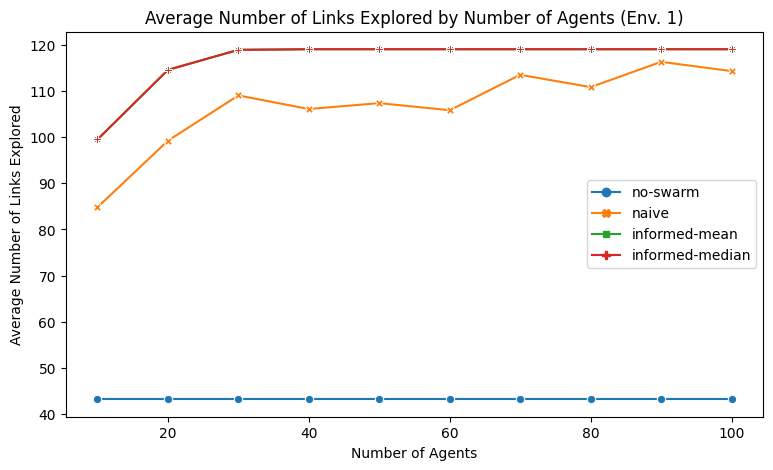

: 

In [64]:
# Plot the average number of links explored for each swarm type and number of agents
fig = plt.figure(figsize=(9, 5))
# Plot the number of agents vs the average number of links explored
ax = sns.lineplot(data=avg_links_explored_10_1, x='num_agents', y='avg_links_explored', hue='swarm_type', style='swarm_type', markers=True, dashes=False)
ax.set_title("Average Number of Links Explored by Number of Agents (Env. 1)")
ax.set_xlabel("Number of Agents")
ax.set_ylabel("Average Number of Links Explored")
ax.legend(loc='center right')
plt.savefig(f"{fig_path}/agent_num_links_env1.png", dpi=300)
plt.savefig(f"{fig_path}/agent_num_links_env1.eps", dpi=300)
    

### Analysis 2 - Environment 2

In [52]:
no_res_env2 = read_results(no_swarm_env2, 'no-swarm')
na_res_env2 = read_results(naive_swarm_env2, 'naive')
im_res_env2 = read_results(informed_mean_swarm_env2, 'informed-mean')
id_res_env2 = read_results(informed_median_swarm_env2, 'informed-median')

no_swarm_results_env2 = pd.concat(no_res_env2)
naive_swarm_results_env2 = pd.concat(na_res_env2)
informed_mean_swarm_results_env2 = pd.concat(im_res_env2)
informed_median_swarm_results_env2 = pd.concat(id_res_env2)

results_10_2 = pd.concat([no_swarm_results_env2, naive_swarm_results_env2, informed_mean_swarm_results_env2, informed_median_swarm_results_env2])

In [53]:
avg_links_explored_10_2 = get_avg_links_explored_df(results_10_2)
avg_links_explored_10_2.sample(5)

,swarm_type,num_agents,avg_links_explored
25,informed-mean,60,281.533333
0,no-swarm,10,64.266667
37,informed-median,80,299.933333
8,no-swarm,90,64.266667
14,naive,50,202.533333


In [55]:
pivot_env2 = get_avg_links_explored_pivot(results_10_2)
pivot_env2

swarm_type,informed-mean,informed-median,naive,no-swarm
num_agents,,,,
10,179.066667,179.066667,134.533333,64.266667
20,233.800000,233.800000,155.066667,64.266667
30,258.466667,258.466667,176.466667,64.266667
40,263.800000,263.800000,183.800000,64.266667
50,269.066667,269.066667,202.533333,64.266667
60,281.533333,281.533333,218.866667,64.266667
70,298.466667,298.466667,216.266667,64.266667
80,299.933333,299.933333,212.666667,64.266667
90,308.866667,308.866667,209.133333,64.266667


### Graphs 2 - Environment 2

In [ ]:
# Plot the average number of links explored for each swarm type and number of agents
fig = plt.figure(figsize=(9, 5))
# Plot the number of agents vs the average number of links explored
ax = sns.lineplot(data=avg_links_explored_10_2, x='num_agents', y='avg_links_explored', hue='swarm_type', style='swarm_type', markers=True, dashes=False)
ax.set_title("Average Number of Links Explored by Number of Agents (Env. 2)")
ax.set_xlabel("Number of Agents")
ax.set_ylabel("Average Number of Links Explored")
ax.legend(loc='bottom right')
plt.savefig(f"{fig_path}/agent_num_links_env2.png", dpi=300)
plt.savefig(f"{fig_path}/agent_num_links_env2.eps", dpi=300)
    